In [1]:
# Author: Michael Djaballah
# Last edited 01:47 AM June 21, 2020
# Last edited by: Michael Djaballah

import yfinance as yf
import pandas as pd
from datetime import datetime
import os
from time import sleep, time
from dateutil.relativedelta import relativedelta
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
'''
Variable ordering
- Portfolio
- ticker(s)
- features
- model
- date
- date format
- historical depth
- training depth
- start
- end
- interval
- data path
'''

'\nVariable ordering\n- Portfolio\n- ticker(s)\n- features\n- model\n- date\n- date format\n- historical depth\n- training depth\n- start\n- end\n- interval\n- data path\n'

In [3]:
data_path = 'data/'
start = '2000-01-01'
interval = '1mo'

In [4]:
# Functions to maintain and call the S&P 500 from a current date
# Author Michael Djaballah
# Time last edited: 01:47 AM June 21, 2020
# Last edited by: Michael Djaballah

# Takes no input
# Output is newly saved CSV's containing the current makeup of the S&P 500 
# and its historical additions and removals
# data_path is changeable depending on desired save location
def get_snp_store(data_path='data/'):
    curr_raw = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    
    curr = curr_raw[0]
    hist = curr_raw[1]
    
    new_hist = pd.DataFrame(hist['Date'])
    new_hist['Added'] = hist['Added', 'Ticker']
    new_hist['Removed'] = hist['Removed', 'Ticker']
    
    os.makedirs(data_path, exist_ok=True)
    
    curr.to_csv(data_path + 'snp_current.csv', index=False)
    new_hist.to_csv(data_path + 'snp_hist.csv', index=False)
    return None


# Input: a date in string form with its corresponding format:
# Ex: 'January 1, 2020', '%B %d, %Y'
# Output: a list containing the S&P 500 at the input date
def build_snp(date, date_format='%Y-%m-%d', data_path='data/'):
#     get_snp_store(data_path=data_path)
    
    date_format2 = '%B %d, %Y'
    
    curr = pd.read_csv(data_path + 'snp_current.csv')
    hist = pd.read_csv(data_path + 'snp_hist.csv')
    
    start_date = datetime.strptime(date, date_format)
    
    snp_set = set(curr['Symbol'])
    
    for i in range(len(hist)):
        temp_date = datetime.strptime(hist.iloc[i]['Date'], date_format2)
        if temp_date < start_date:
            break

        tb_removed = hist.iloc[i]['Added']
        tb_added = hist.iloc[i]['Removed']

        if tb_removed in snp_set:
            snp_set.remove(tb_removed)
        if not type(tb_added) == float:
            snp_set.add(tb_added)
    
    return list(snp_set)

In [5]:
# Functions to obtain data from yfinance
# Author Michael Djaballah
# Time last edited: 01:47 AM June 21, 2020
# Last edited by: Michael Djaballah

# Takes a list of tickers as strings
# Output is newly saved CSV's with one CSV per company with daily data
# Saved in specific directory
# data_path is changeable depending on desired save location
def get_data(tickers, start='2000-01-01', data_path='data/', get_new=False):
    interval = '1d'
    prefix = interval + '/'
    
    os.makedirs(data_path + prefix, exist_ok=True)
    
    if get_new:
        curr_tickers = set()
    else:
        curr_tickers = set(os.listdir(data_path + prefix))
    
    for ticker in tickers:
        ticker_label = ticker + '.csv'
        
        if ticker_label not in curr_tickers:
            temp_ticker = yf.Ticker(ticker)
            temp_hist = temp_ticker.history(start=start, interval=interval)
            temp_hist.reset_index(inplace=True)
            temp_hist.dropna(axis=0, inplace=True)
            temp_hist.to_csv(data_path + prefix + ticker_label, index=False)
            sleep(.5)
            
    return None


# Input: Ticker 
# Output: Takes daily data already downloaded and extracts monthly data
# To be used with a set of other functions for intervals named "build_" + interval
# 
def build_1mo(ticker, data_path='data/'):
    if '.csv' in ticker:
        ticker_df = pd.read_csv(data_path + '1d/' + ticker)
    else:
        ticker_df = pd.read_csv(data_path + '1d/' + ticker + '.csv')
        
    date_format = '%Y-%m-%d'
    
    # These are hardcoded and should be more changed if more flexibility is desired
    data_start = '2000-01-01'
    data_end = '2020-05-01'
    
    month_list = list(pd.date_range(data_start, data_end, freq='MS').strftime(date_format))
    
    # Not currently coded for Dividends or Stock Splits
    months_dict = {
        'Date' : [], 
        'Open' : [], 
        'High' : [], 
        'Low' : [], 
        'Close' : [], 
        'Volume' : []
    }
    
    for start in month_list:
        end = datetime.strptime(start, date_format) + relativedelta(months=1) - relativedelta(days=1)
        end = datetime.strftime(end, date_format)
        
        month_df = ticker_df.set_index('Date')[start:end].reset_index()
        
        if len(month_df) > 0:
            months_dict['Date'].append(start)
            months_dict['Open'].append(month_df.iloc[0]['Open'])
            months_dict['High'].append(max(month_df['High']))
            months_dict['Low'].append(min(month_df['Low']))
            months_dict['Close'].append(month_df.iloc[-1]['Close'])
            months_dict['Volume'].append(sum(month_df['Volume']))
    
    months_df = pd.DataFrame.from_dict(months_dict)
    return months_df


# Input: Interval (string) that is in the list of approved
# Output: Data extracted from previously downloaded daily data in 
# a similarly named directory
# The commented out interval set is to be developed 
def build_data(interval, data_path='data/'):
#     interval_set = {'1mo', '5d', '1wk', '3mo'}
    interval_set = {'1mo'}
    if interval not in interval_set:
        print('Invalid interval')
        return -1
    
    prefix = interval + '/'
    
    os.makedirs(data_path + prefix, exist_ok=True)
    
    ticker_labels = os.listdir(data_path + '1d/')
    
    interval_function = globals()['build_' + interval]
    
    for ticker_label in ticker_labels:
        ticker_df = interval_function(ticker_label)
        ticker_df.to_csv(data_path + prefix + ticker_label, index=False)
    return None

In [6]:
# Took 4 min 30 secs for S&P 2015-01-01
# %%time
# build_data('1mo')

In [7]:
# Functions to manipulate and extract desired data from data saved with "get_data"
# Author Michael Djaballah
# Time last edited: 01:47 AM June 21, 2020
# Last edited by: Michael Djaballah


# Takes a ticker as a string
# Output is either a dataframe with desired data, or False, indicating that there was not enough data to build with the desired offset
# data_path is changeable depending on desired save location
def check_ticker(ticker, offset, interval = '1mo', data_path='data/'):
    prefix = interval + '/'
    ticker_df = pd.read_csv(data_path + prefix + ticker + '.csv')
    if len(ticker_df) >= offset:
        return ticker_df
    return False


# Takes a list of tickers as strings, the test depth and historical depth
# Output is a dictionary of data frames: key = ticker string, value = dataframe
# data_path is changeable depending on desired save location
def build_portfolio(tickers, hist_depth, train_depth, start='2000-01-01', interval='1mo', data_path='data/', offset=True, get_new=False):
    if type(offset) == bool:
        offset = train_depth + hist_depth + 60 + 6
        
    prefix = interval + '/'
    
    get_data(tickers, data_path=data_path, start=start, get_new=get_new)
    
    ticker_dict = {}
    
    for ticker in tickers:
        ticker_df = check_ticker(ticker, offset, data_path=data_path)
        if type(ticker_df) != bool:
            ticker_dict[ticker] = ticker_df
    
    return ticker_dict


# Takes a portfolio (from 'build_portfolio'), a desired ticker, date desired to predict on, depth desired, and features desired
# Output is a dataframe with one row or the desired features from previous dates
# Can change 'keep_pred' to True if training or False if predicting
# Target value is present in 'Target' column if 'keep_pred' = True
def build_feature_vector(portfolio, ticker, features, date, hist_depth, target='Close', keep_pred=True):
    ticker_df = portfolio[ticker]
    
    start_date_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=hist_depth)
    start_date = start_date_dt.strftime('%Y-%m-%d')
    
    feature_df = ticker_df.set_index('Date')[start_date:date].reset_index(drop=True)[features]
    
    new_df_dict = {}
    
    for i in range(len(feature_df)):
        for col in feature_df.columns:
            if i < len(feature_df) - 1:
                new_df_dict[col + ' ' + str(i + 1)] = [feature_df[col].iloc[i]]
            elif col == target:
                if keep_pred:
                    new_df_dict['Target'] = [feature_df[col].iloc[i]]
                    
    new_df = pd.DataFrame.from_dict(new_df_dict)
    
    if keep_pred:
        new_df = new_df[[col for col in new_df.columns if col not in {'Target'}] + ['Target']]
    
    return new_df

In [37]:
# 
# Author Michael Djaballah
# Time last edited: 01:47 AM June 21, 2020
# Last edited by: Michael Djaballah

# Input: portfolio, features, date that the training is to go to, both depths
# Output: dataframe with all features for all training months for the portfolio
# 
# 
def build_train_df(portfolio, features, date, hist_depth, train_depth, target='Close'):    
    tickers = portfolio.keys()
    
    vector_list = []
    for ticker in tickers:
        for i in range(train_depth):
            train_start_dt = datetime.strptime(date, '%Y-%m-%d') - relativedelta(months=(1+i))
            train_start = train_start_dt.strftime('%Y-%m-%d')
            vector_list.append(build_feature_vector(portfolio, ticker, features, train_start, hist_depth, target=target))
            
    feature_df = pd.concat(vector_list)
    return feature_df.reset_index(drop=True)


# Input: portfolio, features, date, historical depth
# Output: dataframe missing y's to predict with and an index list to show which ticker is where in the dataframe
# Returns in a tuple that must be unpacked
# 
def build_test_df(portfolio, features, date, hist_depth, target='Close'):
    tickers = portfolio.keys()
    
    vector_list = []
    index_list = []
    for ticker in tickers:
        vector_list.append(build_feature_vector(portfolio, ticker, features, date, hist_depth, target=target, keep_pred=False))
        index_list.append(ticker)
        
    test_df = pd.concat(vector_list)
    return test_df.reset_index(drop=True), index_list


# Input: portfolio, desired list of tickers to get returns for, and the date of those returns
# Output: list of returns for those tickers
# 
# 
def build_returns(portfolio, tickers, date):
    returns = []
    for ticker in tickers:
        temp_ticker_dict = portfolio[ticker].set_index('Date').loc[date]
        returns.append((temp_ticker_dict['Close'] - temp_ticker_dict['Open'])/temp_ticker_dict['Open'])
    return returns


# Input: Portfolio, ticker, and desired date 
# Output: Whether or not the data has the specific date
# This is to tell if a certain ticker exists on a certain date
# 
def check_date(portfolio, ticker, date):
    dates = set(portfolio[ticker]['Date'])
    return date in dates


# Input: Portfolio, date
# Output: None, this directly edits the portfolio
# This can be changed to reduce side effects, but it is used 
# to remove tickers that are no longer needed moving forward in a backtest
def clean_portfolio(portfolio, date):
    tickers = list(portfolio.keys())
    bad_tickers = []
    for ticker in tickers:
        if not check_date(portfolio, ticker, date):
            bad_tickers.append(ticker)
    for bad_ticker in bad_tickers:
        del portfolio[bad_ticker]
    return None


# Input: Dataframe
# Output: Dataframe scaled to standard
# 
# 
def build_scaled_df(dataframe):
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(dataframe)
    scaled_dataframe = pd.DataFrame(scaled_array, columns=dataframe.columns)
    return scaled_dataframe


# Input: Portfolio, model, date, features, and depths
# Output: 
# 
# 
def build_machine(portfolio, features, model, date, hist_depth, train_depth):
    train_df = build_train_df(portfolio, features, date, hist_depth, train_depth)
    scaled_train_df = build_scaled_df(train_df)
    
    scaled_train_df.dropna(axis=0, inplace=True)
    
    X = scaled_train_df.values[:,:-1]
    y = scaled_train_df.values[:, -1]
    model.fit(X, y)
    
    test_df, tickers = build_test_df(portfolio, features, date, hist_depth)
    scaled_test_df = build_scaled_df(test_df)
    X_test = scaled_test_df.values
    
    predicted_returns = list(model.predict(X))
    
    returns_dict = {}
    
    for i in range(len(tickers)):
        returns_dict[tickers[i]] = predicted_returns[i]
    
    return returns_dict


# Input: Returns dictionary and fixed long short parameters
# Output: Allocation dictionary for long and short tickers
# 
# 
def fixed_long_short(returns_dict, long=15, short=0):
    allocation = {
        'long' : [], 
        'short' : []
    }
    top = sorted(returns_dict.items(), key=lambda x: x[1])[::-1]
    sorted_tickers = [x[0] for x in top]
    
    allocation['long'] = sorted_tickers[:long]
    if short == 0:
        allocation['short'] = []
    else:
        allocation['short'] = sorted_tickers[-1 * short:]
#     print('long: ')
#     print(allocation['long'])
#     print('short: ')
#     print(allocation['short'])
    
    return allocation
    

# Input: all things needed to build a machine with a date range to test
# Output: per date average returns as determined by the model
# 
# 
def backtest(portfolio, features, model, hist_depth, train_depth, start_date, end_date, 
             allocation_builder=fixed_long_short, params={}, blacklist=set()):
    months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))
    
    for ticker in blacklist:
        if ticker in portfolio:
            del portfolio[ticker]
    
    overall_returns = []
    for month in months:
        start_time = time()
        
        clean_portfolio(portfolio, month)
        
        returns_dict = build_machine(portfolio, features, model, month, hist_depth, train_depth)
    
        allocation = allocation_builder(returns_dict, **params)
        
        long_returns = build_returns(portfolio, allocation['long'], month)
        short_returns = build_returns(portfolio, allocation['short'], month)
        short_returns = [short_return * -1 for short_return in short_returns]
        total_returns = long_returns + short_returns
        average_returns = sum(total_returns)/len(total_returns)
        
        # to be implemented: specific historic returns
        
        overall_returns.append(average_returns)
        
        print(month, round(average_returns, 5), round(time() - start_time, 2))
    
    return overall_returns

In [38]:
hist_depth = 12
train_depth = 4
features = ['Close', 'Volume']
start_date = '2015-01-01'
end_date = '2019-12-01'
params = {
    'long' : 30, 
    'short' : 3
}

In [39]:
universe = build_snp('2015-01-01')

In [40]:
%%time
port2 = build_portfolio(universe, hist_depth, train_depth)
print(len(port2.keys()))

435
CPU times: user 1.08 s, sys: 71 ms, total: 1.15 s
Wall time: 1.33 s


In [41]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [42]:
rfr = RandomForestRegressor(n_estimators=10, random_state=410, n_jobs=-1)
# rfr = GradientBoostingRegressor(n_estimators=1000, random_state=407)

In [43]:
%%time
results = backtest(port2, features, rfr, hist_depth, train_depth, start_date, end_date, params=params)

2015-01-01 -0.01951 11.86
2015-02-01 0.07343 11.5
2015-03-01 -0.00629 11.55
2015-04-01 -0.01354 11.55
2015-05-01 0.01354 11.89
2015-06-01 -0.02526 11.6
2015-07-01 0.01058 11.48
2015-08-01 -0.03901 11.71
2015-09-01 0.0037 11.65
2015-10-01 0.03886 11.66
2015-11-01 0.00768 11.71
2015-12-01 -0.02866 11.73
2016-01-01 -0.03436 11.69
2016-02-01 0.02506 12.36
2016-03-01 0.03535 12.05
2016-04-01 -0.00525 11.82
2016-05-01 0.0147 11.78
2016-06-01 0.02705 11.89
2016-07-01 0.03599 12.38
2016-08-01 0.00426 11.92
2016-09-01 -0.01007 11.97
2016-10-01 -0.00826 11.87
2016-11-01 0.03564 12.2
2016-12-01 -0.00296 12.67
2017-01-01 0.02003 12.63
2017-02-01 0.04151 11.97
2017-03-01 -0.00358 12.5
2017-04-01 -0.00078 12.61
2017-05-01 -0.00559 12.33
2017-06-01 0.01125 12.19
2017-07-01 0.06317 12.08
2017-08-01 -0.01296 12.16
2017-09-01 0.03751 12.0
2017-10-01 0.01697 11.98
2017-11-01 0.03875 12.13
2017-12-01 0.0124 11.98
2018-01-01 0.02806 11.94
2018-02-01 -0.03017 12.09
2018-03-01 0.00054 11.79
2018-04-01 0.0366

In [44]:
starting_capital = 100
historical = [starting_capital]
for i in range(len(results)):
    starting_capital *= (results[i] + 1)
    historical.append(starting_capital)

In [45]:
historical[-1], (historical[-1]/100)**(1/5), min(historical)

(160.0985895606334, 1.098695893201628, 97.55540110576143)

In [46]:
spy = yf.Ticker('SPY').history(period='max', interval='1mo').reset_index().dropna()
port3 = {'SPY': spy}
months = list(pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m-%d'))

starting_capital = 100
historical_spy = [starting_capital]
for month in months:
    returns = build_returns(port3, ['SPY'], month)[0]
    starting_capital *= (returns + 1)
    historical_spy.append(starting_capital)
    
df_dict = {'SPY': historical_spy, 'Port':historical}
compare_df = pd.DataFrame.from_dict(df_dict)

In [47]:
historical_spy[-1], (historical_spy[-1]/100)**(1/5), min(historical_spy)

(149.72619165922305, 1.0840755652449479, 93.8068232860004)

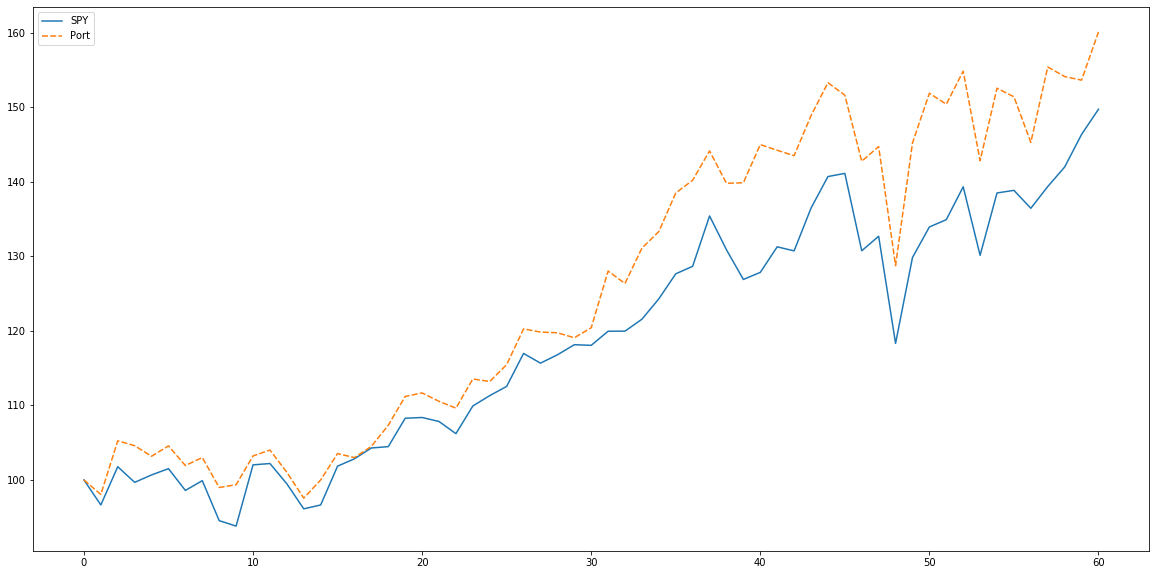

In [48]:
fig_dims = (20,10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=compare_df)

In [ ]:
# For hist=12, train=3, took 7s
# %%time
# build_train_df(port2, features, '2015-01-01', hist_depth, train_depth)

In [ ]:
# For hist=12, train=3, took 2s
# %%time
# test_df, ticker_list = build_test_df(port2, features, '2015-01-01', hist_depth)